## Data Import

In [1]:
import pandas as pd

In [2]:
df_bb = pd.read_csv('/content/imdb_barbie_Uncleaned.csv', header=None)
df_op = pd.read_csv('/content/imdb_oppenhimmer_Uncleaned.csv', header=None)
df_bb.drop_duplicates(inplace=True)
df_op.drop_duplicates(inplace=True)

## Data Cleaning

In [3]:
import re

score_Reg = '(\d{1,2})\/\d{1,2}\s.*\s'
title_Reg = '\d{1,2}\/\d{1,2}\s(.*)'
people_found_helpful_Reg = '([\d,]*) out of ([\d,]*) found this helpful'
username_Reg = '\d{1,2}\/\d{1,2}\s.*\s([A-Za-z0-9_-]+)\d{2}\s(?:January|February|March|April|June|July|August|September|October|November|December)'
date_Reg = '(\d{1,2}\s(?:January|February|March|April|June|July|August|September|October|November|December)\s\d{4})'
review_Reg = '\d{1,2}\s\w+\s\d{4}\s([\s\S]*)\s[\d,]* out of [\d,]* found this helpful'

In [4]:
def get_cleaned_df(dirty_df):
    # cleaned_df = pd.DataFrame(columns=['score', 'title', 'username', 'date', 'people_found_helpful', 'review'])
    cleaned_df = pd.DataFrame(columns=['score', 'title', 'username', 'date', 'people_found_helpful', 'total_people_viewed', 'review'])

    for index in range(len(dirty_df)):
        row = dirty_df.iloc[index][0]

        score = re.findall(score_Reg, row)
        title = re.findall(title_Reg, row)
        username = re.findall(username_Reg, row)
        date = re.findall(date_Reg, row)
        people_found_helpful = re.findall(people_found_helpful_Reg, row)
        review = re.findall(review_Reg, row)

        if not score:
            continue
        else:
            score = int(score[0])
        if not title:
            title = ['NULL']
        if not username:
            username = ['NULL']
        if not date:
            date = ['NULL']
        if not people_found_helpful:
            people_found_helpful = 'NULL'
            total_people_viewed = 'NULL'
        else:
            total_people_viewed = int(people_found_helpful[0][1].replace(',', ''))
            people_found_helpful = int(people_found_helpful[0][0].replace(',', ''))
        if not review:
            review = ['NULL']

        cleaned_df.loc[index] = [score, title[0], username[0], date[0], people_found_helpful, total_people_viewed, review[0]]
    return cleaned_df

In [5]:
cleaned_df_bb = get_cleaned_df(df_bb)
cleaned_df_bb.drop_duplicates(subset=['username'], inplace=True)

cleaned_df_op = get_cleaned_df(df_op)
cleaned_df_op.drop_duplicates(subset=['username'], inplace=True)

In [6]:
cleaned_df_bb['isBarbie'] = 1
cleaned_df_op['isBarbie'] = 0

df = pd.concat([cleaned_df_bb, cleaned_df_op], ignore_index=True)

## Get Numeric Data

In [7]:
numeric_df = pd.DataFrame(columns=['isBarbie', 'score', 'date', 'people_found_helpful', 'total_people_viewed', 'helpful_ratio','length_of_title', 'length_of_username', 'length_of_review'])

numeric_df['isBarbie'] = df['isBarbie']
numeric_df['score'] = df['score']
numeric_df['date'] = df['date']
numeric_df['total_people_viewed'] = df['total_people_viewed']
numeric_df['people_found_helpful'] = df['people_found_helpful']
numeric_df['helpful_ratio'] = df['people_found_helpful'] / df['total_people_viewed']
numeric_df['length_of_title'] = df['title'].apply(lambda x: len(x))
numeric_df['length_of_username'] = df['username'].apply(lambda x: len(x))
numeric_df['length_of_review'] = df['review'].apply(lambda x: len(x))

# numeric_df = numeric_df[~numeric_df['date'].str.contains('IMAX')]
numeric_df['date'] = pd.to_datetime(df['date'], format='%d %B %Y')
numeric_df['date_from_release'] = (numeric_df['date'] - pd.to_datetime('2023-07-23', format='%Y-%m-%d')).dt.days

## Data Explore

<ipython-input-8-5d6e87dc5d47>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=drop_na_df.corr(), ax=ax1, cmap=cmap, annot=True)


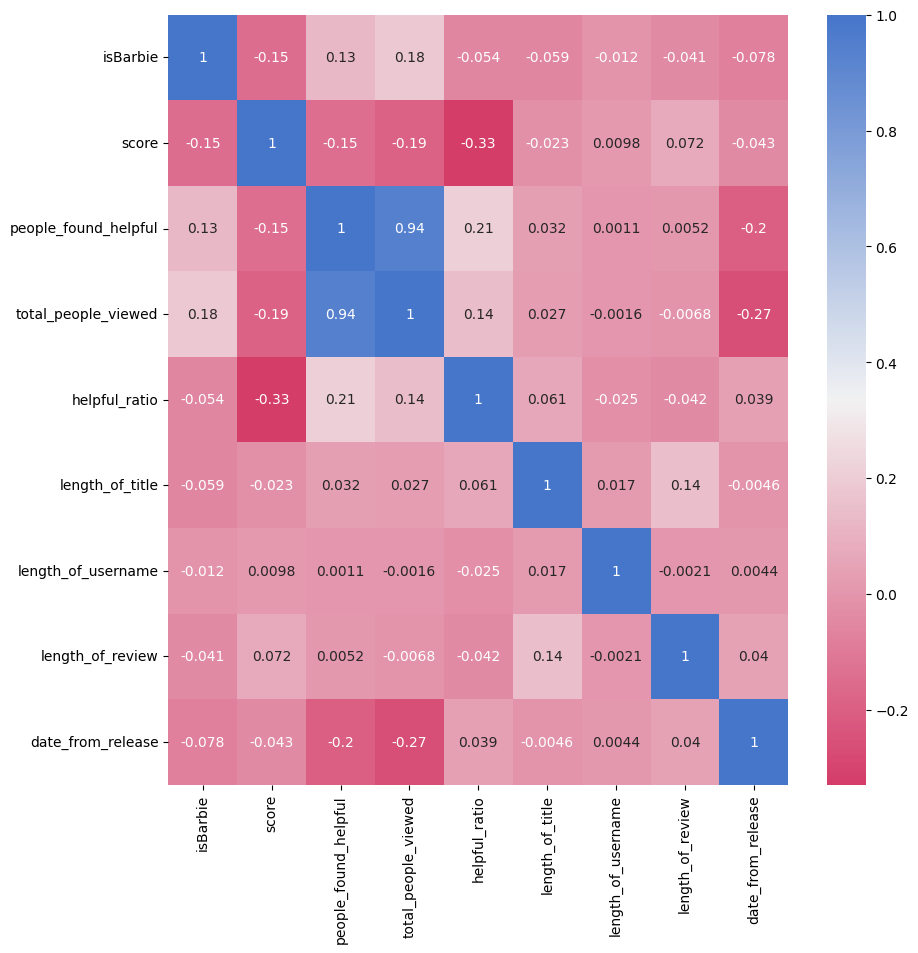

In [8]:
# Coorelation Matrix
import matplotlib.pyplot as plt
import seaborn as sns

drop_na_df = numeric_df[numeric_df['score'] != 'NULL']

fig1 = plt.figure(figsize=(10, 10))
ax1 = fig1.add_subplot(111)

cmap = sns.diverging_palette(0, 255, n=256, as_cmap=True)

sns.heatmap(data=drop_na_df.corr(), ax=ax1, cmap=cmap, annot=True)

plt.show()

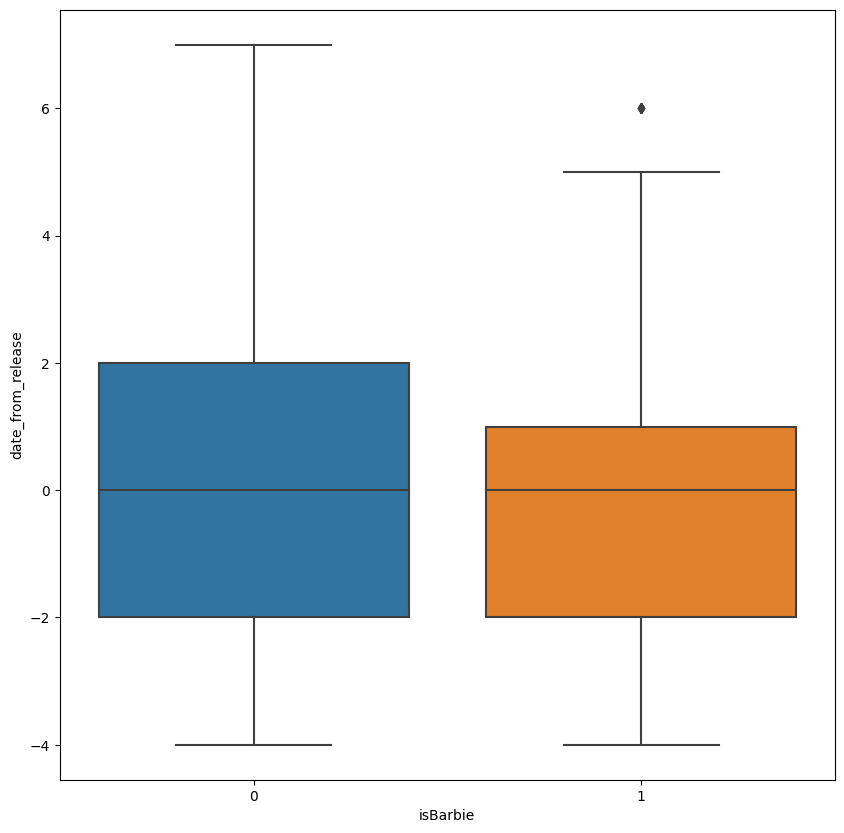

In [9]:
fig2 = plt.figure(figsize=(10, 10))
ax2 = fig2.add_subplot(111)

sns.boxplot(data=numeric_df, x='isBarbie', y='date_from_release', ax=ax2)

plt.show()

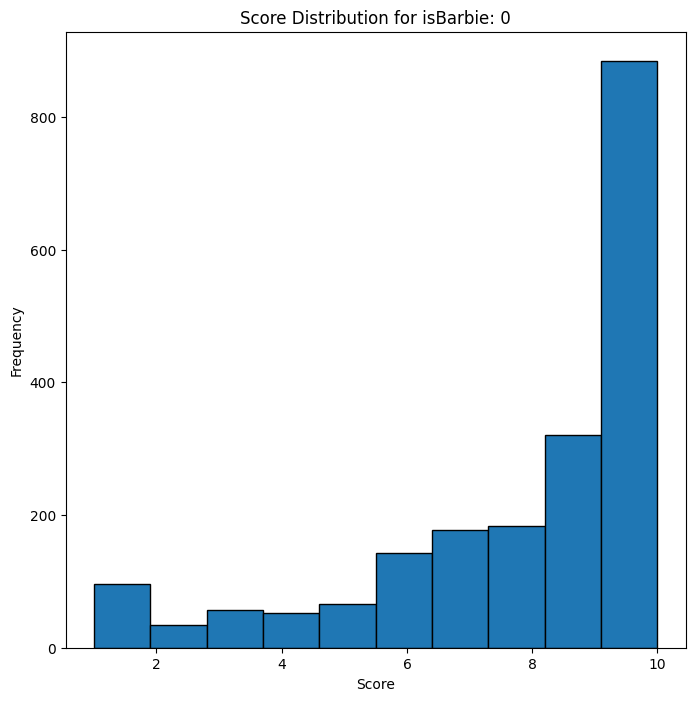

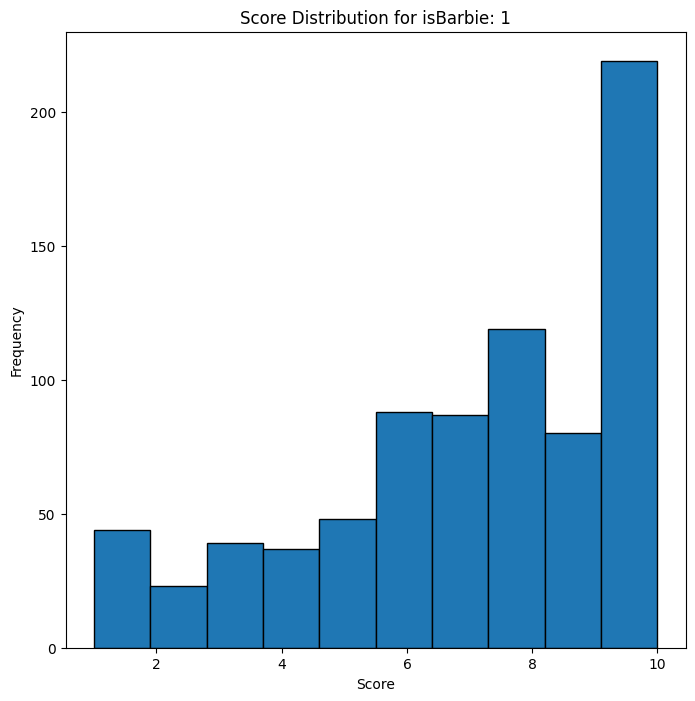

In [10]:
group_by = df.groupby('isBarbie')
for movie_id, group_data in group_by:
    plt.figure(figsize=(8, 8))
    plt.hist(group_data['score'], edgecolor='black')
    plt.title(f'Score Distribution for isBarbie: {movie_id}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

## Modeling

In [11]:
def get_bert_data(dff):
    return dff[['review', 'isBarbie']].copy()


def get_BoW_data(dff):
    from sklearn.feature_extraction.text import CountVectorizer
    BoW_text_data = dff[['review', 'isBarbie']].copy()

    reviews = BoW_text_data['review']
    vectorizer = CountVectorizer()

    X = vectorizer.fit_transform(reviews)
    BoW_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return pd.concat([dff['isBarbie'], BoW_df], axis=1)


def get_ANN_data(dff):
    opp_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Oppenheimer'] + count['oppenheimer']
        opp_inst.append(amount)

    # Calculates the number of instances the word "Barbie" was used
    barbie_inst = []

    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Barbie'] + count['barbie']
        barbie_inst.append(amount)

    # Calculates the number of instances the word "movie" was used
    movie_inst = []

    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Movie'] + count['movie']
        movie_inst.append(amount)

    # Calculates the number of instances the word "war" was used
    war_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['War'] + count['war']
        war_inst.append(amount)

    # Calculates the number of instances the word "woman" was used
    woman_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Woman'] + count['woman'] + count['Women'] + count['women']
        woman_inst.append(amount)

    # Calculates the number of instances the actress Margot Robbie from Barbie was mentioned
    margot_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Margot'] + count['margot'] + count['Robbie'] + count['robbie']
        margot_inst.append(amount)

    # Calculates the number of instances the actor Ryan Gosling or Ken from Barbie was mentioned
    ken_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Ryan'] + count['ryan'] + count['Gosling'] + count['gosling'] + count['Ken'] + count['ken']
        ken_inst.append(amount)

    # Calculates the number of instances the actress Emily Blunt or Kitty from Oppenheimer was mentioned
    kitty_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Emily'] + count['emily'] + count['Blunt'] + count['blunt'] + count['Kitty'] + count['kitty']
        kitty_inst.append(amount)

    # Calculates the number of instances the actor Cillian Murphy from Oppenheimer was mentioned
    cillian_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i].split())
        amount = count['Cillian'] + count['cillian'] + count['Murphy'] + count['murphy']
        cillian_inst.append(amount)

    # Calculates the number of instances an exclamation mark was used
    excl_inst = []
    from collections import Counter
    for i in range(len(df['review'])):
        count = Counter(df['review'][i])
        amount = count['!']
        excl_inst.append(amount)

    new_df = pd.DataFrame()
    new_df['opp_inst'] = opp_inst
    new_df['barbie_inst'] = barbie_inst
    new_df['movie_inst'] = movie_inst
    new_df['war_inst'] = war_inst
    new_df['woman_inst'] = woman_inst
    new_df['margot_inst'] = margot_inst
    new_df['ken_inst'] = ken_inst
    new_df['cillian_inst'] = cillian_inst
    new_df['kitty_inst'] = kitty_inst
    new_df['excl_inst'] = excl_inst
    new_df['score'] = numeric_df['score']
    new_df['date_from_release'] = numeric_df['date_from_release']
    new_df['isBarbie'] = numeric_df['isBarbie']
    return new_df.sample(frac=1)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = df.sample(frac=1, random_state=42)

train, test = train_test_split(df, test_size=0.2, shuffle=False)

Bert_train = get_bert_data(train)
Bert_X_train = Bert_train.drop(columns='isBarbie')
Bert_y_train = Bert_train['isBarbie']
Bert_test = get_bert_data(test)
Bert_X_test = Bert_test.drop(columns='isBarbie')
Bert_y_test = Bert_test['isBarbie']

BoW_df = get_BoW_data(df)
BoW_train, BoW_test = train_test_split(BoW_df, test_size=0.2, shuffle=False)
# Index order is kept but index is discarded in extraction
BoW_X_train = BoW_train.drop(columns='isBarbie')
BoW_y_train = BoW_train['isBarbie']
BoW_X_test = BoW_test.drop(columns='isBarbie')
BoW_y_test = BoW_test['isBarbie']

ANN_df = get_ANN_data(df)
ANN_train, ANN_test = train_test_split(ANN_df, test_size=0.2, shuffle=False)
ANN_X_train = ANN_train.drop(columns='isBarbie')
ANN_y_train = ANN_train['isBarbie']
ANN_X_test = ANN_test.drop(columns='isBarbie')
ANN_y_test = ANN_test['isBarbie']

normalize = MinMaxScaler()
ANN_X_train = normalize.fit_transform(ANN_X_train)
ANN_X_test = normalize.transform(ANN_X_test)


### BERT

In [13]:
# def get_bert_data():
#     return df[['review', 'title', 'isBarbie']].copy()
#
# bert_text_data = get_bert_data()

In [14]:
from sklearn.model_selection import train_test_split

# Bert_X_train, Bert_X_test, Bert_y_train, Bert_y_test = train_test_split(bert_text_data.drop(columns = ['isBarbie', 'title']), bert_text_data['isBarbie'], stratify=bert_text_data['isBarbie'], test_size = 0.2, random_state = 42)
# Bert_X_train, Bert_X_test, Bert_y_train, Bert_y_test = train_test_split(bert_text_data.drop(columns = ['isBarbie', 'title']), bert_text_data['isBarbie'], test_size = 0.2, random_state = 42)


In [15]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text as text

bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [16]:
from keras.layers import Dense, Input
from keras.optimizers import Adam

# BERT layers
text_input = Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = Dense(1, activation='sigmoid')(l)

# Use inputs and outputs to construct a final model
bert_model = tf.keras.Model(inputs=[text_input], outputs = [l])

bert_model.compile(optimizer = Adam(learning_rate = 0.2), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
# bert_history = bert_model.fit(Bert_X_train, Bert_y_train, batch_size = 512, epochs = 1)

### Bag of Words

In [18]:
# from sklearn.feature_extraction.text import CountVectorizer
#
# def get_BoW_data():
#     BoW_text_data = df[['review', 'isBarbie']].copy()
#
#     reviews = BoW_text_data['review']
#     vectorizer = CountVectorizer()
#
#     X = vectorizer.fit_transform(reviews)
#     BoW_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
#     return pd.concat([BoW_df, BoW_text_data['isBarbie']], axis=1)

In [19]:
from sklearn.tree import DecisionTreeClassifier

# BoW_df = get_BoW_data()
#
# BoW_X_train, BoW_X_test, BoW_y_train, BoW_y_test = train_test_split(BoW_df.drop(columns='isBarbie'), BoW_df['isBarbie'], test_size=0.2, random_state=42)

BoW_decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)

In [20]:
# BoW_decision_tree.fit(BoW_X_train, BoW_y_train)

### ANN

In [21]:
# def get_ANN_data():
#     from collections import Counter
#     opp_inst = []
#     for i in range(len(df['review'])):
#         count = Counter(df['review'][i].split())
#         amount = count['Oppenheimer'] + count['oppenheimer']
#         opp_inst.append(amount)
#
#     barbie_inst = []
#     for i in range(len(df['review'])):
#         count = Counter(df['review'][i].split())
#         amount = count['Barbie'] + count['barbie']
#         barbie_inst.append(amount)
#
#     movie_inst = []
#     for i in range(len(df['review'])):
#         count = Counter(df['review'][i].split())
#         amount = count['Movie'] + count['movie']
#         movie_inst.append(amount)
#
#     excl_inst = []
#     from collections import Counter
#     for i in range(len(df['review'])):
#         count = Counter(df['review'][i])
#         amount = count['!']
#         excl_inst.append(amount)
#
#     new_df = pd.DataFrame()
#     new_df['opp_inst'] = opp_inst
#     new_df['barbie_inst'] = barbie_inst
#     new_df['movie_inst'] = movie_inst
#     new_df['excl_inst'] = excl_inst
#     new_df['score'] = numeric_df['score']
#     new_df['date_from_release'] = numeric_df['date_from_release']
#     new_df['isBarbie'] = numeric_df['isBarbie']
#     return new_df.sample(frac=1)

In [22]:
# ANN_Data = get_ANN_data()
# ANN_X_train, ANN_X_test, ANN_y_train, ANN_y_test = train_test_split(ANN_Data.drop(columns='isBarbie'),ANN_Data['isBarbie'], test_size=0.2, random_state=42)

In [23]:
!pip install scikeras

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

ANN = Sequential()

ANN.add(Dense(units=16, activation='sigmoid', input_shape=(ANN_X_train.shape[1],)))
ANN.add(Dense(units=8, activation='sigmoid'))
ANN.add(Dense(units=4, activation='sigmoid'))
ANN.add(Dense(units=1, activation='sigmoid'))

opt = Adam(learning_rate=1e-03)

ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# ANN_history = ANN.fit(ANN_X_train, ANN_y_train, epochs=100, batch_size=16)

## Training

In [ ]:
bert_history = bert_model.fit(Bert_X_train, Bert_y_train, batch_size = 512, epochs = 10)

In [27]:
BoW_decision_tree.fit(BoW_X_train, BoW_y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [28]:
ANN_history = ANN.fit(ANN_X_train, ANN_y_train, epochs=60, batch_size=32, validation_data=(ANN_X_test, ANN_y_test))

Epoch 1/60
70/70 [==============================] - 5s 13ms/step - loss: 0.5956 - accuracy: 0.7184 - val_loss: 0.5878 - val_accuracy: 0.7250
Epoch 2/60
70/70 [==============================] - 1s 8ms/step - loss: 0.5937 - accuracy: 0.7184 - val_loss: 0.5872 - val_accuracy: 0.7250
Epoch 3/60
70/70 [==============================] - 1s 8ms/step - loss: 0.5929 - accuracy: 0.7184 - val_loss: 0.5862 - val_accuracy: 0.7250
Epoch 4/60
70/70 [==============================] - 0s 6ms/step - loss: 0.5919 - accuracy: 0.7184 - val_loss: 0.5852 - val_accuracy: 0.7250
Epoch 5/60
70/70 [==============================] - 1s 9ms/step - loss: 0.5908 - accuracy: 0.7184 - val_loss: 0.5838 - val_accuracy: 0.7250
Epoch 6/60
70/70 [==============================] - 1s 21ms/step - loss: 0.5890 - accuracy: 0.7184 - val_loss: 0.5823 - val_accuracy: 0.7250
Epoch 7/60
70/70 [==============================] - 1s 8ms/step - loss: 0.5871 - accuracy: 0.7184 - val_loss: 0.5796 - val_accuracy: 0.7250
Epoch 8/60
70/70 [

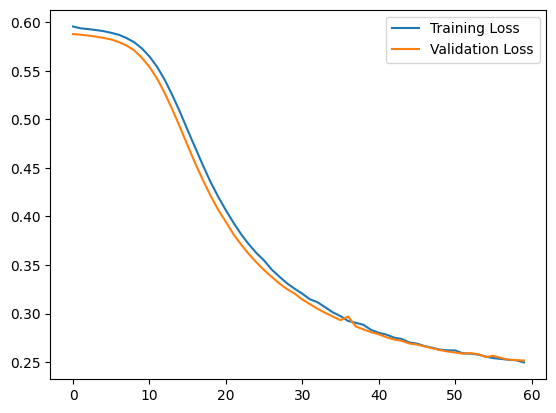

In [29]:
import matplotlib.pyplot as plt

plt.plot(ANN_history.history['loss'], label = "Training Loss")
plt.plot(ANN_history.history['val_loss'], label = "Validation Loss")
plt.legend()

### Grid Search

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model():
  ANN = Sequential()
  ANN.add(Dense(units=16, activation='sigmoid', input_shape=(ANN_X_train.shape[1],)))
  ANN.add(Dense(units=8, activation='sigmoid'))
  ANN.add(Dense(units=4, activation='sigmoid'))
  ANN.add(Dense(units=1, activation='sigmoid'))
  opt = Adam(learning_rate=1e-03)
  ANN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return ANN

model = KerasClassifier(model = create_model)

epochs = [10, 50, 100]
batch_size = [32, 64, 128]
param_grid = dict(epochs = epochs, batch_size = batch_size)

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = 10)
result = grid_search.fit(ANN_X_train, ANN_y_train)

best_model = result.best_estimator_
result.best_params_

Streaming output truncated to the last 5000 lines.
Epoch 52/100
63/63 [==============================] - 1s 12ms/step - loss: 0.2899 - accuracy: 0.8947
Epoch 53/100
63/63 [==============================] - 1s 11ms/step - loss: 0.2864 - accuracy: 0.8947
Epoch 54/100
63/63 [==============================] - 1s 14ms/step - loss: 0.2830 - accuracy: 0.8972
Epoch 55/100
63/63 [==============================] - 1s 12ms/step - loss: 0.2832 - accuracy: 0.8957
Epoch 56/100
63/63 [==============================] - 0s 7ms/step - loss: 0.2787 - accuracy: 0.8967
Epoch 57/100
63/63 [==============================] - 1s 8ms/step - loss: 0.2763 - accuracy: 0.8967
Epoch 58/100
63/63 [==============================] - 0s 7ms/step - loss: 0.2733 - accuracy: 0.8982
Epoch 59/100
63/63 [==============================] - 0s 7ms/step - loss: 0.2722 - accuracy: 0.8982
Epoch 60/100
63/63 [==============================] - 0s 7ms/step - loss: 0.2696 - accuracy: 0.8992
Epoch 61/100
63/63 [=========================

2/2 [==============================] - 0s 4ms/step
Epoch 1/10
16/16 [==============================] - 2s 4ms/step - loss: 0.6031 - accuracy: 0.7183
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.5982 - accuracy: 0.7183
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.5953 - accuracy: 0.7183
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.5944 - accuracy: 0.7183
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.5941 - accuracy: 0.7183
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.5940 - accuracy: 0.7183
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.5939 - accuracy: 0.7183
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.5936 - accuracy: 0.7183
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.5935 - accuracy: 0.7183
Epoch 10/10
16/16 [==============================] - 0s 5ms/step - 

2/2 [==============================] - 0s 4ms/step
Epoch 1/10
16/16 [==============================] - 2s 5ms/step - loss: 0.8713 - accuracy: 0.2817
Epoch 2/10
16/16 [==============================] - 0s 6ms/step - loss: 0.8301 - accuracy: 0.2817
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 0.7933 - accuracy: 0.2817
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 0.7615 - accuracy: 0.2817
Epoch 5/10
16/16 [==============================] - 0s 5ms/step - loss: 0.7338 - accuracy: 0.2817
Epoch 6/10
16/16 [==============================] - 0s 5ms/step - loss: 0.7100 - accuracy: 0.2817
Epoch 7/10
16/16 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5688
Epoch 8/10
16/16 [==============================] - 0s 5ms/step - loss: 0.6726 - accuracy: 0.7183
Epoch 9/10
16/16 [==============================] - 0s 5ms/step - loss: 0.6585 - accuracy: 0.7183
Epoch 10/10
2/2 [==============================] - 0s 4ms/step
Epoc

{'batch_size': 32, 'epochs': 100}

### Customized Ensemble

In [31]:
# print(Bert_y_test.head())
# print(BoW_y_test.head())
# print(ANN_y_test.head())

In [32]:
bert_train_yhat = bert_model.predict(Bert_X_train)
BoW_train_yhat = BoW_decision_tree.predict(BoW_X_train).reshape(BoW_X_train.shape[0], 1)
ANN_train_yhat = ANN.predict(ANN_X_train)

70/70 [==============================] - 0s 2ms/step


In [33]:
from sklearn.metrics import classification_report

bert_train_yhat = [1 if yhat > 0.5 else 0 for yhat in bert_train_yhat]
BoW_train_yhat = [1 if yhat > 0.5 else 0 for yhat in BoW_train_yhat]
ANN_train_yhat = [1 if yhat > 0.5 else 0 for yhat in ANN_train_yhat]

print('BERT Train')
print(classification_report(bert_train_yhat, Bert_y_train))
print('========================================')
print('BoW Train')
print(classification_report(BoW_train_yhat, BoW_y_train))
print('========================================')
print('ANN Train')
print(classification_report(ANN_train_yhat, ANN_y_train))

BERT Train
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      2232
           1       0.00      0.20      0.00         5

    accuracy                           0.71      2237
   macro avg       0.50      0.46      0.42      2237
weighted avg       1.00      0.71      0.83      2237

BoW Train
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      2159
           1       0.09      0.71      0.15        78

    accuracy                           0.73      2237
   macro avg       0.54      0.72      0.50      2237
weighted avg       0.95      0.73      0.81      2237

ANN Train
              precision    recall  f1-score   support

           0       0.99      0.88      0.94      1810
           1       0.66      0.98      0.79       427

    accuracy                           0.90      2237
   macro avg       0.83      0.93      0.86      2237
weighted avg       0.93      0.90      0.91

In [34]:
bert_test_yhat = bert_model.predict(Bert_X_test)
BoW_test_yhat = BoW_decision_tree.predict(BoW_X_test)
ANN_test_yhat = ANN.predict(ANN_X_test)

18/18 [==============================] - 0s 2ms/step


In [35]:
bert_test_yhat = [1 if yhat > 0.5 else 0 for yhat in bert_test_yhat]
BoW_test_yhat = [1 if yhat > 0.5 else 0 for yhat in BoW_test_yhat]
ANN_test_yhat = [1 if yhat > 0.5 else 0 for yhat in ANN_test_yhat]

print('BERT Test')
print(classification_report(bert_test_yhat, Bert_y_test))
print('========================================')
print('BoW Test')
print(classification_report(BoW_test_yhat, BoW_y_test))
print('========================================')
print('ANN Test')
print(classification_report(ANN_test_yhat, ANN_y_test))

BERT Test
              precision    recall  f1-score   support

           0       1.00      0.75      0.85       557
           1       0.01      0.67      0.03         3

    accuracy                           0.74       560
   macro avg       0.51      0.71      0.44       560
weighted avg       0.99      0.74      0.85       560

BoW Test
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       530
           1       0.05      0.23      0.08        30

    accuracy                           0.71       560
   macro avg       0.50      0.49      0.46       560
weighted avg       0.90      0.71      0.79       560

ANN Test
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       457
           1       0.66      0.98      0.79       103

    accuracy                           0.90       560
   macro avg       0.83      0.93      0.86       560
weighted avg       0.93      0.90      0.91   

In [36]:
ensemble_X_train = pd.concat([pd.DataFrame(bert_train_yhat), pd.DataFrame(BoW_train_yhat), pd.DataFrame(ANN_train_yhat)], axis=1)
# ensemble_X_train = pd.concat([pd.DataFrame(BoW_train_yhat), pd.DataFrame(ANN_train_yhat)], axis=1)
ensemble_y_train = train['isBarbie']

ensemble_X_test = pd.concat([pd.DataFrame(bert_test_yhat), pd.DataFrame(BoW_test_yhat), pd.DataFrame(ANN_test_yhat)], axis=1)

# ensemble_X_test = pd.concat([pd.DataFrame(bert_model.predict(Bert_X_test)), pd.DataFrame(BoW_decision_tree.predict(BoW_X_test).reshape(BoW_X_test.shape[0], 1)), pd.DataFrame(ANN.predict(ANN_X_test))], axis=1)
ensemble_y_test = test['isBarbie']

In [37]:
ensemble_model = Sequential()

ensemble_model.add(Dense(units=3, activation='sigmoid', input_shape=(ensemble_X_train.shape[1],)))
ensemble_model.add(Dense(units=1, activation='sigmoid'))

opt = Adam(learning_rate=1e-04)

ensemble_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
ensemble_history = ensemble_model.fit(ensemble_X_train, ensemble_y_train, epochs=50, batch_size=8, validation_data=(ensemble_X_test, ensemble_y_test))

Epoch 1/50
280/280 [==============================] - 2s 4ms/step - loss: 0.6045 - accuracy: 0.7139 - val_loss: 0.5750 - val_accuracy: 0.7429
Epoch 2/50
280/280 [==============================] - 1s 4ms/step - loss: 0.6043 - accuracy: 0.7139 - val_loss: 0.5746 - val_accuracy: 0.7429
Epoch 3/50
280/280 [==============================] - 1s 4ms/step - loss: 0.6041 - accuracy: 0.7139 - val_loss: 0.5742 - val_accuracy: 0.7429
Epoch 4/50
280/280 [==============================] - 1s 4ms/step - loss: 0.6039 - accuracy: 0.7139 - val_loss: 0.5740 - val_accuracy: 0.7429
Epoch 5/50
280/280 [==============================] - 1s 4ms/step - loss: 0.6038 - accuracy: 0.7139 - val_loss: 0.5737 - val_accuracy: 0.7429
Epoch 6/50
280/280 [==============================] - 1s 4ms/step - loss: 0.6036 - accuracy: 0.7139 - val_loss: 0.5735 - val_accuracy: 0.7429
Epoch 7/50
280/280 [==============================] - 1s 4ms/step - loss: 0.6035 - accuracy: 0.7139 - val_loss: 0.5733 - val_accuracy: 0.7429
Epoch 

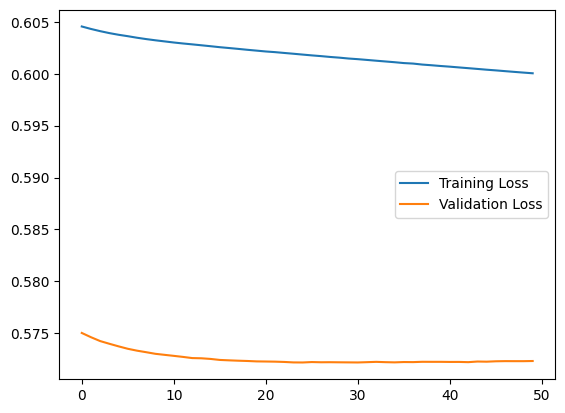

In [39]:
import matplotlib.pyplot as plt

plt.plot(ensemble_history.history['loss'], label = "Training Loss")
plt.plot(ensemble_history.history['val_loss'], label = "Validation Loss")
plt.legend()

In [40]:
ensemble_yhat = ensemble_model.predict(ensemble_X_test)

ensemble_yhat = [1 if yhat > 0.5 else 0 for yhat in ensemble_yhat]

18/18 [==============================] - 0s 3ms/step


In [41]:
from sklearn.metrics import classification_report

print(classification_report(ensemble_yhat, ensemble_y_test))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85       560
           1       0.00      0.00      0.00         0

    accuracy                           0.74       560
   macro avg       0.50      0.37      0.43       560
weighted avg       1.00      0.74      0.85       560



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


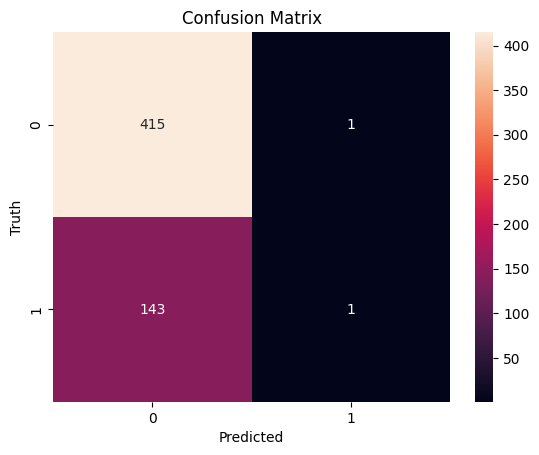

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(ensemble_y_test, ensemble_yhat)

sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

In [50]:
# Simple vote
ensemble_X_test = pd.concat([pd.DataFrame(BoW_test_yhat), pd.DataFrame(ANN_test_yhat)], axis=1)
ensemble_yhat = ensemble_X_test.sum(axis=1)
ensemble_yhat = [1 if yhat > 1 else 0 for yhat in ensemble_yhat]

print(classification_report(ensemble_yhat, ensemble_y_test))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85       558
           1       0.01      0.50      0.01         2

    accuracy                           0.74       560
   macro avg       0.50      0.62      0.43       560
weighted avg       0.99      0.74      0.85       560

